## Title

## Introduction

- Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal
- Clearly state the question you will try to answer with your project
- Identify and describe the dataset that will be used to answer the question

## Preliminary exploratory data analysis
- Demonstrate that the dataset can be read from the web into R 
- Clean and wrangle your data into a tidy format
- **Using only training data**, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
- **Using only training data**, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

In [5]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

variable_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
cleve_data <- read.table("data/processed.cleveland.data", header=TRUE, sep = ",", col.names = variable_names)
cleve_data

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


The above is our inital datatset read from the web. We are using the processed cleveland dataset as it has already been preprocessed -- no additional wrangling is required to make the dataset tidy.

Below, we have selected only the columns that we wish to look at:

In [6]:
cleve_data <- cleve_data |>
                select(age, sex, trestbps, chol, thalach, num)

cleve_data

age,sex,trestbps,chol,thalach,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
67,1,160,286,108,2
67,1,120,229,129,1
37,1,130,250,187,0
⋮,⋮,⋮,⋮,⋮,⋮
57,1,130,131,115,3
57,0,130,236,174,1
38,1,138,175,173,0


We will only be considering the age, sex, trestbps (resting blood pressure), cholesteral, and max heart rate attributes for our predictors as these variables are both important for classifying whether a patient has a healthy heart and easy to understand. 

Now that the data has been filtered to only contain columns of interest, we split it into two subsets -- 75% training and 25% testing. 

In [7]:
set.seed(1)

cleve_split <- initial_split(cleve_data, prop=0.75, strata=num)
cleve_train <- training(cleve_split)
cleve_test <- testing(cleve_split)

cleve_train
cleve_test

age,sex,trestbps,chol,thalach,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
37,1,130,250,187,0
56,1,120,236,178,0
44,1,120,263,173,0
⋮,⋮,⋮,⋮,⋮,⋮
55,0,128,205,130,3
59,1,164,176,90,3
57,1,130,131,115,3


age,sex,trestbps,chol,thalach,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
41,0,130,204,172,0
57,0,120,354,163,0
57,1,140,192,148,0
⋮,⋮,⋮,⋮,⋮,⋮
58,1,114,318,140,4
68,1,144,193,141,2
57,0,130,236,174,1


### Training Data Summary Table

Below is a table containing summary information regarding the number of observations in each class and the means of the predictor variables we selected from above. There are no missing values in any of these columns as stated in the dataset database.

In [10]:
cleve_train_summary <- cleve_train |>
  group_by(num) |>
  summarise(
    across(where(is.numeric), mean, na.rm = TRUE),  
    n = n()
  )

cleve_train_summary

num,age,sex,trestbps,chol,thalach,n
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,52.00813,0.6097561,127.8130,240.2114,159.2358,123
1,55.68293,0.8292683,133.4878,248.7561,144.3171,41
2,57.56000,0.8400000,133.9200,265.0000,132.8000,25
3,55.15385,0.8846154,132.5769,241.7308,133.6538,26
4,58.50000,0.9000000,139.5000,239.5000,140.9000,10


Using the training data, we can also create a histogram to display the distribution of all our predictor variables. This lets us both visualize what our data looks like and conduct a sanity check to make sure our variables make sense. 

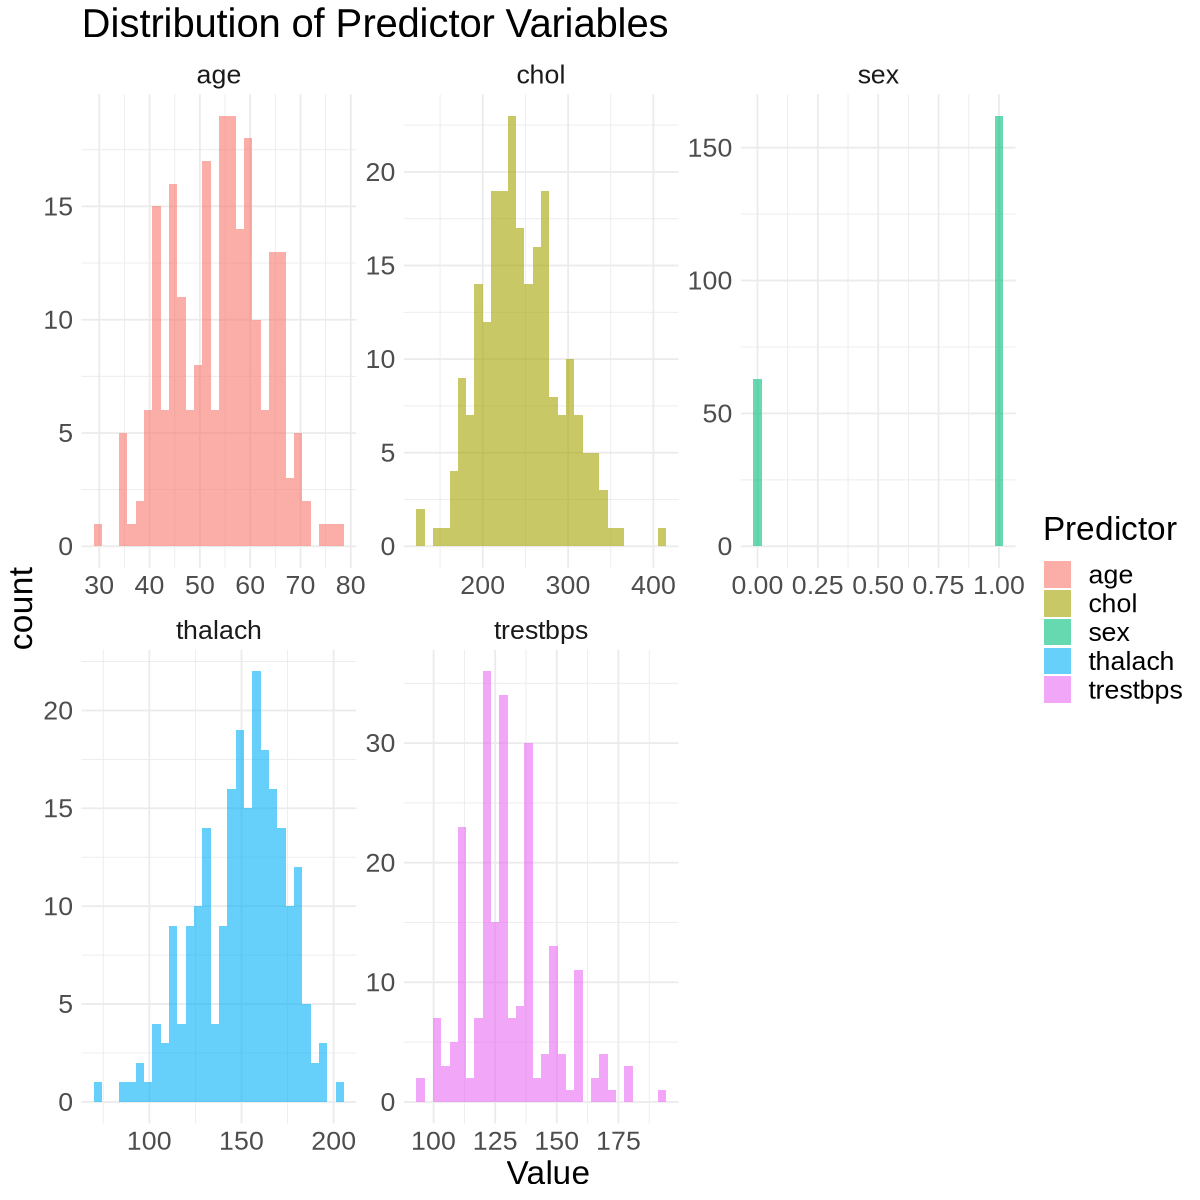

In [13]:
options(repr.plot.width = 10, repr.plot.height = 10)

predictor_variables <- c("age", "sex", "trestbps", "chol", "thalach")

data_long <- pivot_longer(cleve_train, cols = predictor_variables, names_to = "Predictor", values_to = "Value")

plot <- ggplot(data_long, aes(x = Value, fill = Predictor)) +
  geom_histogram(bins = 30, alpha = 0.6, position = "identity") +
  facet_wrap(~ Predictor, scales = "free") +
  theme_minimal() +
  labs(title = "Distribution of Predictor Variables") +
  theme(text = element_text(size = 20)) 

plot

## Methods
- Explain how you will conduct either your data analysis and which variables/columns you will use. <ins>Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?</ins>
- Describe at least one way that you will visualize the results


## Expected outcomes and significance
- What do you expect to find?
- What impact could such findings have?
- What future questions could this lead to?
